In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects

from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

  markers = ('o', 's', '^', 'v', '<')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
  np.arange(x2_min, x2_max, resolution))
  lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  lab = lab.reshape(xx1.shape)
  plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0],
                y=X[y == cl, 1],
                alpha=0.8,
                c=colors[idx],
                marker=markers[idx],
                label=f'Class {cl}',
                edgecolor='black')

  if test_idx:

    X_test, y_test = X[test_idx, :], y[test_idx]
    plt.scatter(X_test[:, 0], X_test[:, 1],
                c='none', edgecolor='black', alpha=1.0,
                linewidth=1, marker='o',
                s=100, label='Test set')

In [5]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

## PCA

1. Estandarizar los datos
2. Construir la matriz de covarianzas
3. Obtener los valores propios y los vectores propios de la matriz de covarianzas
4. Ordenar los valores propios en orden descendente

![](https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/bf62496f44a92a21d23250d5ed13d2d2e617e0e2/ch05/images/05_01.png)

### PCA a mano

In [6]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
    stratify=y,
    random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [11]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


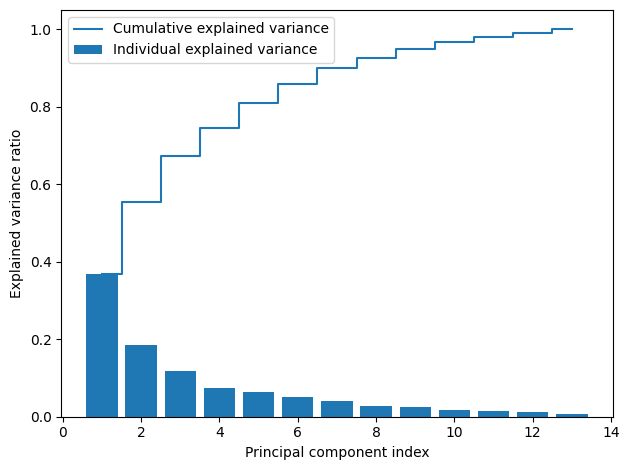

In [12]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
      sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1,14), var_exp, align='center',
      label='Individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
      label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [13]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
    for i in range(len(eigen_vals))]

eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [14]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
    eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [17]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

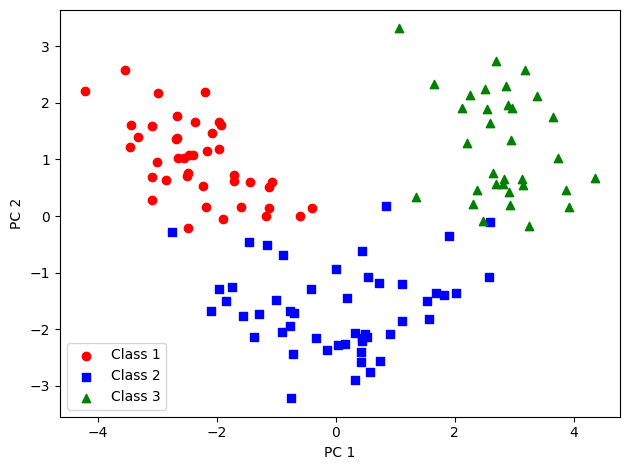

In [18]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
    X_train_pca[y_train==l, 1],
    c=c, label=f'Class {l}', marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### PCA con sklearn

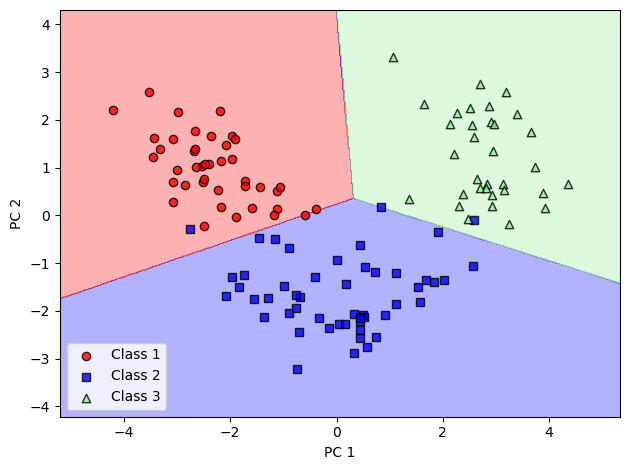

In [19]:
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr',
    random_state=1,
    solver='lbfgs')

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

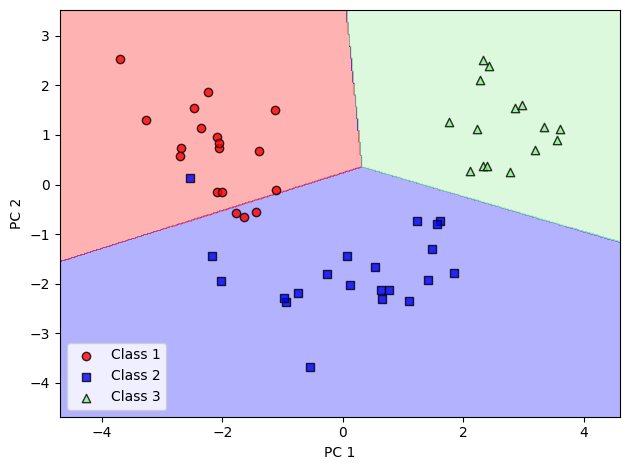

In [20]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [21]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### Evaluar el aporte

In [23]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

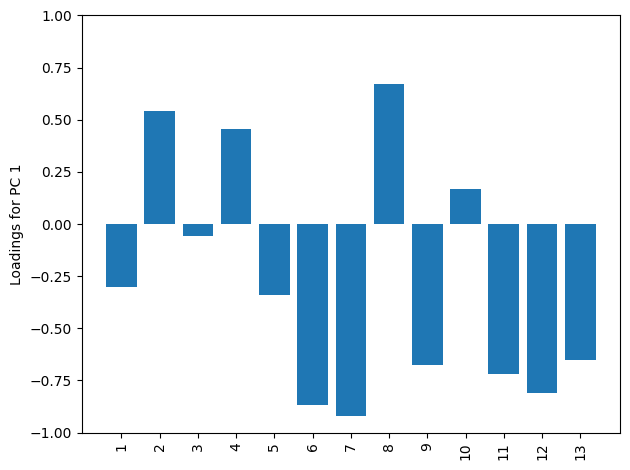

In [24]:
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [25]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

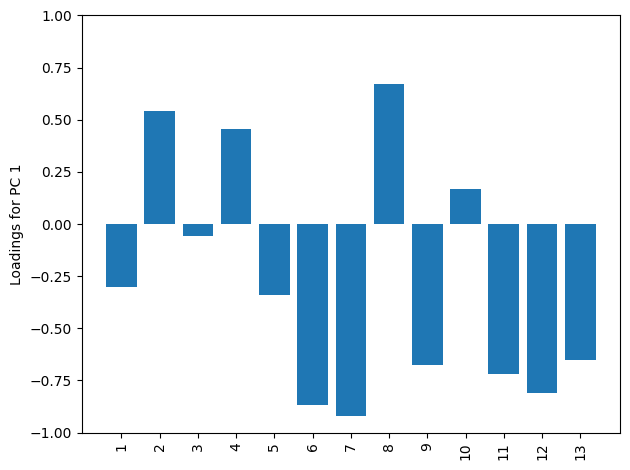

In [26]:
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## t-SNE

In [27]:
digits = load_digits()

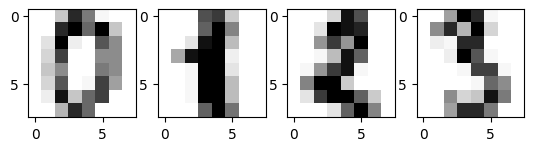

In [30]:
fig, ax = plt.subplots(1, 4)
for i in range(4):
  ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

In [31]:
digits.data.shape

(1797, 64)

In [32]:
y_digits = digits.target
X_digits = digits.data

In [43]:
X_digits[15].reshape(8, 8)

array([[ 0.,  5., 12., 13., 16., 16.,  2.,  0.],
       [ 0., 11., 16., 15.,  8.,  4.,  0.,  0.],
       [ 0.,  8., 14., 11.,  1.,  0.,  0.,  0.],
       [ 0.,  8., 16., 16., 14.,  0.,  0.,  0.],
       [ 0.,  1.,  6.,  6., 16.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  5., 16.,  3.,  0.,  0.],
       [ 0.,  1.,  5., 15., 13.,  0.,  0.,  0.],
       [ 0.,  4., 15., 16.,  2.,  0.,  0.,  0.]])

In [44]:
y_digits[15]

5

In [33]:
tsne = TSNE(n_components=2, init='pca', random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

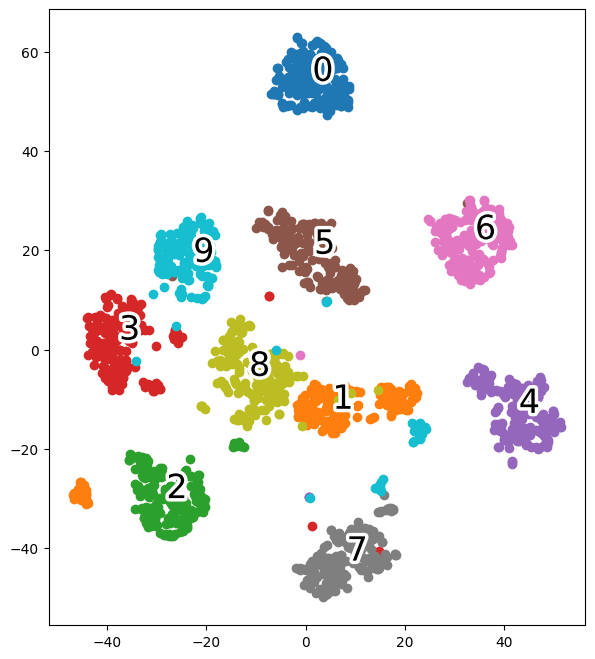

In [34]:
def plot_projection(x, colors):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
      plt.scatter(x[colors == i, 0],
                  x[colors == i, 1])
    for i in range(10):
      xtext, ytext = np.median(x[colors == i, :], axis=0)
      txt = ax.text(xtext, ytext, str(i), fontsize=24)
      txt.set_path_effects([
          PathEffects.Stroke(linewidth=5, foreground="w"),
          PathEffects.Normal()])

plot_projection(X_digits_tsne, y_digits)
plt.show()

Tomado de Raschka, S (2023). con fines educativos.